In [13]:
import numpy as np

# Percorsi ai file
X = np.load("dataset_75/images.npy")
y = np.load("dataset_75/labels.npy")

X = X.astype("float32") / 255.0

X = X[..., np.newaxis]

print(X.shape)  # es. (18000, 150, 150) o (18000, 75, 75)
print(y.shape)  # es. (18000, 2)



(18000, 75, 75, 1)
(18000, 2)


In [24]:
label_range=30 #minutes the are togheter in the same class
number_of_classifiers=12*60//label_range

label=(y[:,0]*60 + y[:,1])//label_range

print(label[17999])
print(y[17999])
print(number_of_classifiers)

23
[11 59]
24


In [15]:
from sklearn.model_selection import train_test_split

X_traina, X_test, y_traina, y_test = train_test_split(X, label, test_size=0.1, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_traina, y_traina, test_size=y_test.shape[0], random_state=42, shuffle=True)

print(X_test.shape)
print(X_val.shape)
print(X_train.shape)
print(X_train[0].shape)

(1800, 75, 75, 1)
(1800, 75, 75, 1)
(14400, 75, 75, 1)
(75, 75, 1)


In [16]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras import layers, models, regularizers
from keras.optimizers import AdamW
from keras.callbacks import ReduceLROnPlateau


In [17]:
model_base = models.Sequential([
    keras.layers.Conv2D(32, (5,5), padding="same", input_shape=X_train[0].shape),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.MaxPooling2D(),
    #keras.layers.Dropout(0.3),

    keras.layers.Conv2D(64, (3,3), padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.AveragePooling2D(2,2),
    #keras.layers.Dropout(0.3),

    keras.layers.Conv2D(128, (3,3), padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.AveragePooling2D(2,2),
    #keras.layers.Dropout(0.3),

    keras.layers.Conv2D(256, (3,3), padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.AveragePooling2D(2,2),
    #keras.layers.Dropout(0.3),    

    keras.layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.4),
    layers.Dense(number_of_classifiers, activation="softmax")

])

/vol/home/s4949404/miniconda3/envs/IDL/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
model_base.compile(
    optimizer=AdamW(learning_rate=5e-4, weight_decay=5e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [19]:
# Reduce LR when validation loss stops improving
lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6
)

checkpoint = keras.callbacks.ModelCheckpoint(
    "best_model.keras",
    save_best_only=True
)

early_stopping=keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True
)

In [20]:
history_base = model_base.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[lr_scheduler,checkpoint,early_stopping]
)


Epoch 1/100


225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.0875 - loss: 2.9971 - val_accuracy: 0.0411 - val_loss: 6.1864 - learning_rate: 5.0000e-04
Epoch 2/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.1760 - loss: 2.4834 - val_accuracy: 0.0483 - val_loss: 11.7748 - learning_rate: 5.0000e-04
Epoch 3/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.2725 - loss: 2.1418 - val_accuracy: 0.0367 - val_loss: 7.5918 - learning_rate: 5.0000e-04
Epoch 4/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4034 - loss: 1.7397 - val_accuracy: 0.1072 - val_loss: 5.4110 - learning_rate: 5.0000e-04
Epoch 5/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5558 - loss: 1.2883 - val_accuracy: 0.0589 - val_loss: 15.1050 - learning_rate: 5.0000e-04
Epoch 6/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6572 - loss: 0.9852 - val_accuracy: 0.0500 - val_loss: 12.9802 - learning_rate: 5.0000e-04
Epoch 7/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accur

In [21]:
# Carichiamo il modello salvato con i pesi migliori
best = keras.models.load_model("best_model.keras")

# Valutiamo sul test set
test_loss, test_acc = best.evaluate(X_train, y_train)
print(f"Loss sul train set: {test_loss:.4f}")
print(f"Accuratezza sul train set: {test_acc:.4f}")

# Valutiamo sul test set
test_loss, test_acc = best.evaluate(X_test, y_test)
print(f"Loss sul test set: {test_loss:.4f}")
print(f"Accuratezza sul test set: {test_acc:.4f}")

450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 1.0000 - loss: 0.0377
Loss sul train set: 0.0377
Accuratezza sul train set: 1.0000
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9822 - loss: 0.0922
Loss sul test set: 0.0922
Accuratezza sul test set: 0.9822


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


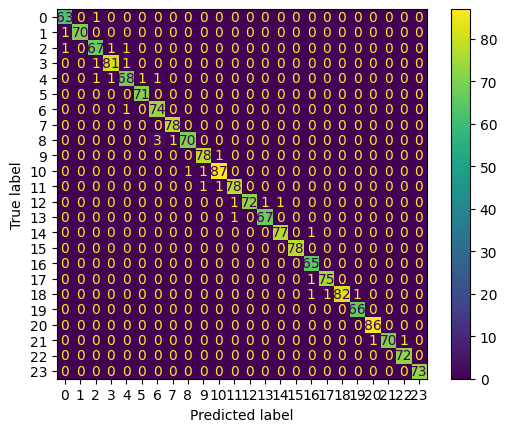

In [22]:
y_pred = model_base.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred_classes)
ConfusionMatrixDisplay(cm).plot()




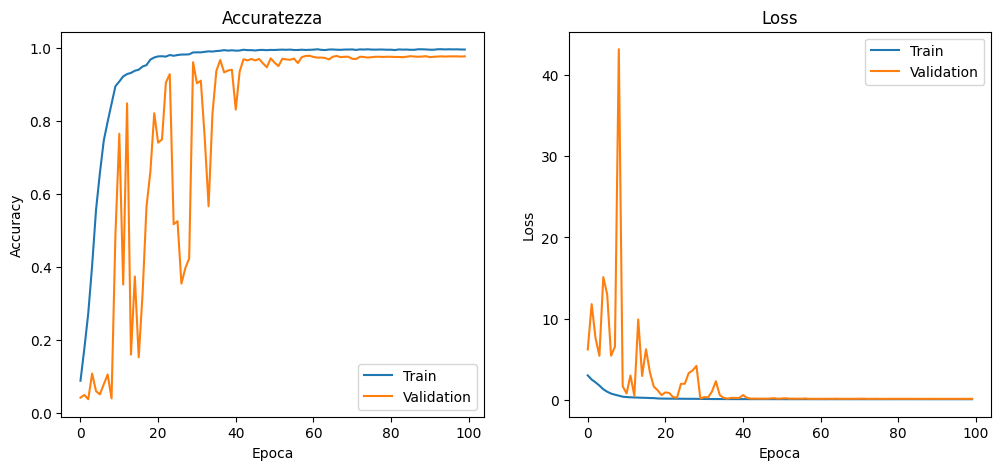

In [23]:
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_base.history["accuracy"], label="Train")
plt.plot(history_base.history["val_accuracy"], label="Validation")
plt.title("Accuratezza")
plt.xlabel("Epoca")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_base.history["loss"], label="Train")
plt.plot(history_base.history["val_loss"], label="Validation")
plt.title("Loss")
plt.xlabel("Epoca")
plt.ylabel("Loss")
plt.legend()

plt.show()